In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit.Chem import AllChem
from tdc.multi_pred import DTI
import pickle
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


### Loading TDC BindingDB_Kd data

In [2]:
# Binding DB dataset
data = DTI(name='BindingDB_Kd')
data.convert_to_log(form = 'binding')
df = data.get_data()
unique_drugs1 = df['Drug'].unique()
unique_targets1 = df['Target'].unique()
print('BindingDB: Ligands:'+str(len(unique_drugs1))+ ' Proteins:'+str(len(unique_targets1)))


Found local copy...
Loading...
Done!
To log space...


BindingDB: Ligands:10661 Proteins:1413


In [3]:
#check if a target is present based on UniprotID\
unique_targets_id= df['Target_ID'].unique()
has_P14416 = 'P14416' in unique_targets_id
has_P14416

True

In [4]:
# Load embeddings
file_path = 'data/embeddings_bindingdb.pkl'
with open(file_path, 'rb') as file:
    embeddings_dict = pickle.load(file)

drug_embeddings = embeddings_dict['Drug_Embedding']
target_embeddings = embeddings_dict['Target_Embedding']
drug_ids = embeddings_dict['Drug_ID']
target_ids = embeddings_dict['Target_ID']

# Filter out NaN values in Drug_ID and Target_ID
df_filtered = df.dropna(subset=['Drug_ID', 'Target_ID'])

# Further filter the dataframe to include only those IDs that are in the embeddings
df_filtered = df_filtered[df_filtered['Drug_ID'].isin(drug_ids) & df_filtered['Target_ID'].isin(target_ids)].reset_index(drop=True)

# Align embeddings with filtered dataframe
drug_id_to_idx = {id: idx for idx, id in enumerate(drug_ids)}
target_id_to_idx = {id: idx for idx, id in enumerate(target_ids)}

filtered_drug_embeddings = np.array([drug_embeddings[drug_id_to_idx[id]] for id in df_filtered['Drug_ID'].unique()])
filtered_target_embeddings = np.array([target_embeddings[target_id_to_idx[id]] for id in df_filtered['Target_ID'].unique()])

In [5]:
df_filtered

,Drug_ID,Drug,Target_ID,Target,Y
0,444607.0,Cc1ccc(CNS(=O)(=O)c2ccc(S(N)(=O)=O)s2)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.251812
1,4316.0,COc1ccc(CNS(=O)(=O)c2ccc(S(N)(=O)=O)s2)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.229148
2,4293.0,NS(=O)(=O)c1ccc(S(=O)(=O)NCc2cccs2)s1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.031517
3,1611.0,NS(=O)(=O)c1cc2c(s1)S(=O)(=O)N(Cc1cccs1)CC2O,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.522879
4,1612.0,COc1ccc(N2CC(O)c3cc(S(N)(=O)=O)sc3S2(=O)=O)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.585027
...,...,...,...,...,...
47936,3019.0,CC1=Nc2ccc(Cl)cc2S(=O)(=O)N1,P43490,MNPAAEAEFNILLATDSYKVTHYKQYPPNTSKVYSYFECREKKTEN...,3.638272
47937,76311095.0,O=C(NCc1ccc(S(=O)(=O)N2CCN(C3COC3)CC2)cc1)c1cc...,P43490,MNPAAEAEFNILLATDSYKVTHYKQYPPNTSKVYSYFECREKKTEN...,7.096367
47938,76311094.0,O=C(NCCCCS(=O)(=O)c1ccccc1)c1ccc2nccn2c1,P43490,MNPAAEAEFNILLATDSYKVTHYKQYPPNTSKVYSYFECREKKTEN...,6.065451
47939,113557.0,CCCCCCCOC1OC(CO)C(O)C(O)C1O,P08191,MKRVITLFAVLLMGWSVNAWSFACKTANGTAIPIGGGSANVYVNLA...,7.767004


In [ ]:
#saving the BindingDB_TDC data removing duplicates and NaN values 
#df_filtered.to_csv('BindingDB_TDC.csv')

### BindingDB_TDC distribution - KDE plot

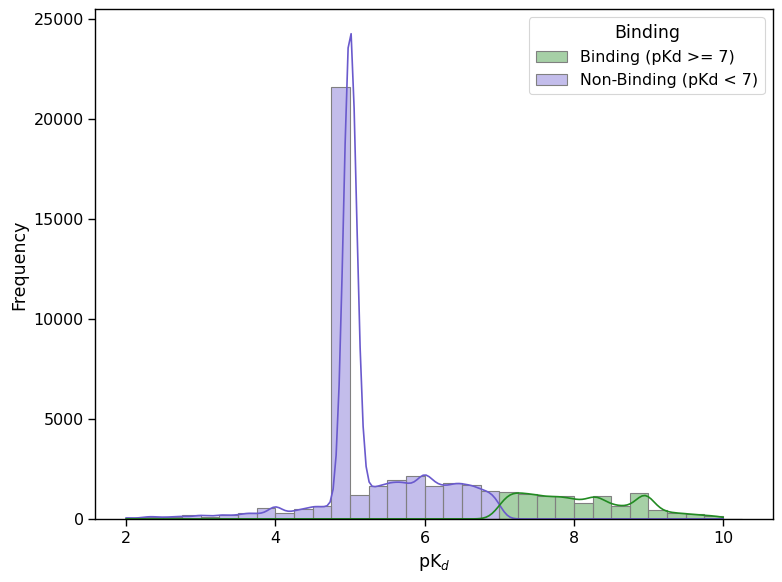

In [27]:
df_cleaned=pd.read_csv('data/BindingDB_TDC.csv')

df_cleaned['Binding'] = np.where(df_cleaned['Y'] >= 7, 'Binding (pKd >= 7)', 'Non-Binding (pKd < 7)')

sns.set_context("paper", font_scale=1.3)

plt.figure(figsize=(8, 6))


sns.histplot(
    data=df_cleaned, 
    x='Y', 
    hue='Binding', 
    kde=True, 
    palette={'Binding (pKd >= 7)': '#228B22', 'Non-Binding (pKd < 7)': '#6A5ACD'}, 
    binwidth=0.25, 
    alpha=0.4,
    edgecolor='grey' 
)

plt.xlabel(r'pK$_d$')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('plots/BindingDB_TDC.png', dpi=500)
plt.show()


### BindingDB cleaned by removing assay limits

In [14]:
### Top 5 assay limits
kd_unique_values = df_filtered['Y'].value_counts().sort_index()

top_5_frequent_kd_values = kd_unique_values.head(5)
top_5_frequent_kd_values = kd_unique_values.sort_values(ascending=False).head(5)
print(top_5_frequent_kd_values)

Y
4.999996    21074
8.958607      832
5.999957      575
8.292430      444
4.000000      316
Name: count, dtype: int64


In [29]:
## Filter the top 5 assay limits
threshold_kd_values = top_5_frequent_kd_values.index.tolist()
df_cleaned = df_filtered[~df_filtered['Y'].isin(threshold_kd_values)]
df_cleaned

,Drug_ID,Drug,Target_ID,Target,Y
0,444607.0,Cc1ccc(CNS(=O)(=O)c2ccc(S(N)(=O)=O)s2)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.251812
1,4316.0,COc1ccc(CNS(=O)(=O)c2ccc(S(N)(=O)=O)s2)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.229148
2,4293.0,NS(=O)(=O)c1ccc(S(=O)(=O)NCc2cccs2)s1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.031517
3,1611.0,NS(=O)(=O)c1cc2c(s1)S(=O)(=O)N(Cc1cccs1)CC2O,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.522879
4,1612.0,COc1ccc(N2CC(O)c3cc(S(N)(=O)=O)sc3S2(=O)=O)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.585027
...,...,...,...,...,...
47936,3019.0,CC1=Nc2ccc(Cl)cc2S(=O)(=O)N1,P43490,MNPAAEAEFNILLATDSYKVTHYKQYPPNTSKVYSYFECREKKTEN...,3.638272
47937,76311095.0,O=C(NCc1ccc(S(=O)(=O)N2CCN(C3COC3)CC2)cc1)c1cc...,P43490,MNPAAEAEFNILLATDSYKVTHYKQYPPNTSKVYSYFECREKKTEN...,7.096367
47938,76311094.0,O=C(NCCCCS(=O)(=O)c1ccccc1)c1ccc2nccn2c1,P43490,MNPAAEAEFNILLATDSYKVTHYKQYPPNTSKVYSYFECREKKTEN...,6.065451
47939,113557.0,CCCCCCCOC1OC(CO)C(O)C(O)C1O,P08191,MKRVITLFAVLLMGWSVNAWSFACKTANGTAIPIGGGSANVYVNLA...,7.767004


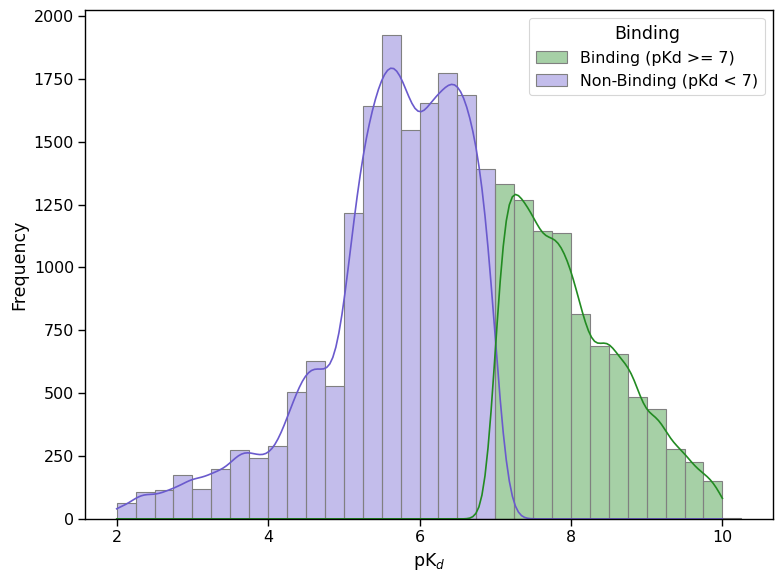

In [16]:

#df_cleaned=pd.read_csv('BindingDB_cleaned.csv')

df_cleaned['Binding'] = np.where(df_cleaned['Y'] >= 7, 'Binding (pKd >= 7)', 'Non-Binding (pKd < 7)')

sns.set_context("paper", font_scale=1.3)

plt.figure(figsize=(8, 6))


sns.histplot(
    data=df_cleaned, 
    x='Y', 
    hue='Binding', 
    kde=True, 
    palette={'Binding (pKd >= 7)': '#228B22', 'Non-Binding (pKd < 7)': '#6A5ACD'}, 
    binwidth=0.25, 
    alpha=0.4,
    edgecolor='grey'
)

plt.xlabel(r'pK$_d$')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('plots/BindingDB_cleaned.png', dpi=500)
plt.show()
